# Feature Scaling and Transformation
- github colab : https://homl.info/colab3
- 어떤 데이터는 1에서 10000사이고 어떤건 1에서 2사이이고 하면 scale이 큰쪽으로 결과가 bias될 가능성이 높다. 특히나 무식하게 distance재서 유사도를 판단한다거나 하는식이면 더더욱 그렇다
- 그래서 데이터를 비슷한 범위 안에서 놀도록 scale해야 한다
	- 근데 데이터가 특성상 비슷한 범위일수가 없으면 어떻게 해야 하려나...
- 여기서 쓸 수 있는 방법이 몇가지 있다
	- min-max를 보고 이걸 이용해 특정 범위(예: 0-1)로 변환하는 것
	- mean과 std를 재서 mean을 빼고 std로 나누는 standardization을 하는 것
	- fat tail같이 한쪽으로 skew되어 있는 bell curve라면 log를 적용한다던지
		- 요런 느낌
	- Bucketization
		- 비슷한 (혹은 같은) 사이즈 단위로 bucket을 나눈다
			- 뭐 상위 10%, 20%, 30%, ..., 100% 이런식으로 나눈다든지
			- 이러면 uniform distribution이 나온다
		- local max가 여러개 있는 multimodal function의 경우 bucketization이 도움이 될 수 있다.
			- 이때는 bucket을 수치로 보기 보다는 one-hot encoding같은걸 사용하는 category로 보는게 나을 수도 있다
        - 예를 들어 애니 판매량이 80년대 한번 peak를 찍고 2000년대에 다시한번 peak를 찍었다면 두개는 연속되는 시계열로 볼게 아니고 각각이 다른 category로 보는게 나을 수 있다
    - Radial basis function
        - 특정 점으로 부터의 거리가 짧아질수록 높아지고 멀어질수록 낮아지는 것
        - 예를 들어 부동산 값을 예측할 때 위도 경도를 볼게 아니라 서울이라는 도시에서 얼마나 멀어지는가를 본다던지 하는 것
        - Gausian RPF같은걸 많이 쓴다고 함

In [2]:
import matplotlib
import matplotlib.pyplot
import numpy
import pathlib
import pandas
import sklearn
import sklearn.compose
import sklearn.impute
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics.pairwise
import sklearn.preprocessing
import tarfile
import urllib

def ch2_load_housing_data():
    tarball_path = pathlib.Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        pathlib.Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pandas.read_csv(pathlib.Path("datasets/housing/housing.csv"))

def matplotlib_to_imagefile(output_dir, filename, imgext="png", tight_layout=True, resolution=300):
    path = output_dir / f"{filename}.{imgext}"
    if tight_layout:
        matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig(path, format=imgext, dpi=resolution)
    
def stratified_sampling_income_category(input_dataframe):
    input_dataframe = input_dataframe.copy()
    input_dataframe["income_cat"] = pandas.cut(input_dataframe["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., numpy.inf],
                               labels=[1, 2, 3, 4, 5])
    s_train, s_test = sklearn.model_selection.train_test_split(input_dataframe, test_size = 0.2, stratify = input_dataframe['income_cat'], random_state = 42)
    s_train.drop('income_cat', axis=1, inplace=True)
    s_test.drop('income_cat', axis=1, inplace=True)
    
    return s_train, s_test
    
# 저장할 디렉토리 설정
output_dir = pathlib.Path() / "images" / "end_to_end_project"
output_dir.mkdir(parents=True, exist_ok=True)
print(f'output_dir : {output_dir}')

input_dataframe = ch2_load_housing_data()
train, test = stratified_sampling_income_category(input_dataframe)

label = train['median_house_value'].copy()
predictor = train.drop('median_house_value', axis = 1)

imputer = sklearn.impute.SimpleImputer(strategy='median')
predictor_numtype = predictor.select_dtypes(include=[numpy.number])
imputer.fit(predictor_numtype)
X = imputer.transform(predictor_numtype)
predictor_numtype = pandas.DataFrame(X, columns = predictor_numtype.columns, index = predictor_numtype.index)

predictor_category = predictor[['ocean_proximity']]
onehot = sklearn.preprocessing.OneHotEncoder()
predictor_category_1hot = onehot.fit_transform(predictor_category)

output_dir : images\end_to_end_project


In [3]:
#
# MinMaxScaler 사용법
#
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)) # min을 -1, max를 1로 매핑
Xminmax = min_max_scaler.fit_transform(predictor_numtype) # numpy.ndarray 가 리턴됨
print(type(Xminmax))
print()
predictor_numtype_minmax_scaled = pandas.DataFrame(Xminmax, columns = predictor_numtype.columns, index = predictor_numtype.index)

print(predictor_numtype[:5])
print()
print(predictor_numtype_minmax_scaled[:5])
print()

<class 'numpy.ndarray'>

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  
13096      1576.0      1034.0         2.0987  
14973       666.0       357.0         6.0876  
3785        562.0       203.0         2.4330  
14689      1845.0       780.0         2.2618  
20507      1912.0      1172.0         3.5292  

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -0.608519  0.117021            1.000000    -0.831171       -0.641166   
14973   0.210953 -0.661702            0.529412    -0.900148

In [4]:
#
# StandardScaler 사용법
# mean을 빼고 standard deviation으로 나눈다
#
std_scaler = sklearn.preprocessing.StandardScaler()
Xstd = std_scaler.fit_transform(predictor_numtype)

predictor_numtype_std_scaled = pandas.DataFrame(Xstd, columns = predictor_numtype.columns, index = predictor_numtype.index)

print(predictor_numtype[:5])
print()
print(predictor_numtype_std_scaled[:5])
print()

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  
13096      1576.0      1034.0         2.0987  
14973       666.0       357.0         6.0876  
3785        562.0       203.0         2.4330  
14689      1845.0       780.0         2.2618  
20507      1912.0      1172.0         3.5292  

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -1.423037  1.013606            1.861119     0.311912        1.368167   
14973   0.596394 -0.702103            0.907630    -0.308620       -0.435925   
3785 

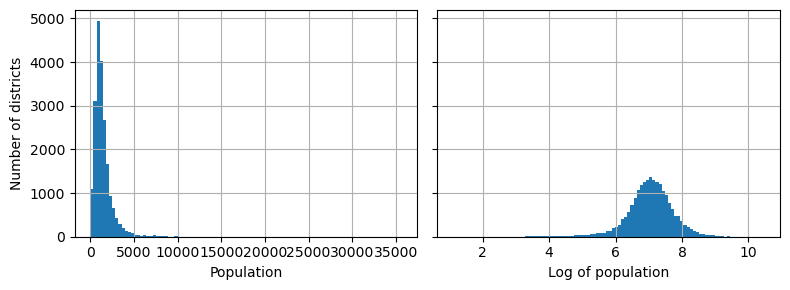

In [5]:
#
# 한쪽으로 skew되어 있는 커브의 경우 log를 적용하면 좀 더 bell-shaped처럼 된다
# bell-shaepd인게 더 선호되는 경우 사용할 수 있는 테크닉
#
fig, axs = matplotlib.pyplot.subplots(1, 2, figsize=(8,3), sharey=True)
input_dataframe['population'].hist(ax=axs[0], bins=100)
input_dataframe['population'].apply(numpy.log).hist(ax=axs[1], bins=100)
axs[0].set_xlabel('Population')
axs[1].set_xlabel('Log of population')
axs[0].set_ylabel('Number of districts')
matplotlib_to_imagefile(output_dir, 'long_tail_log_plot')
matplotlib.pyplot.show()

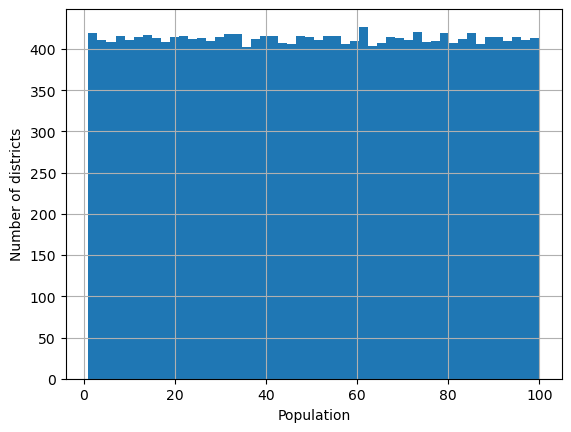

In [6]:
#
# Percentile로 변환하면 uniform distribution에 가까운 것을 얻는다 (당연하다면 당연하다)
#
percentiles = [numpy.percentile(input_dataframe["population"], p)
               for p in range(1, 100)]
flattened = pandas.cut(input_dataframe["population"],
                    bins=[-numpy.inf] + percentiles + [numpy.inf],
                    labels=range(1, 100 + 1))
flattened.hist(bins=50)
matplotlib.pyplot.xlabel("Population")
matplotlib.pyplot.ylabel("Number of districts")
matplotlib.pyplot.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

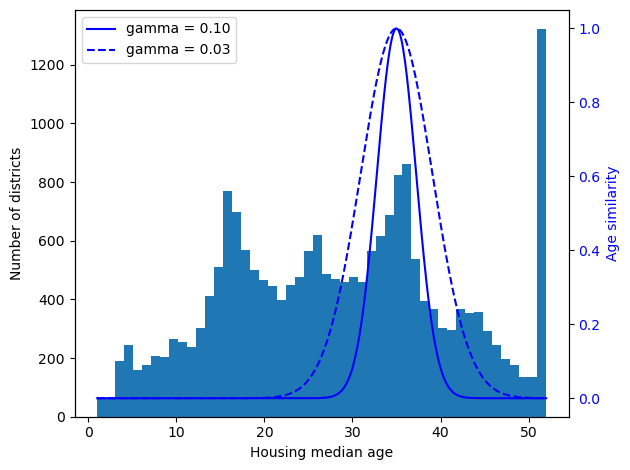

In [7]:
#
# Radial basis function
# housing_median_age같은걸 보면 뭔가 multimodal function스럽게 생겼다
# 이런 경우엔 수치의 높낮이로 볼게 아니라 특정 숫자(피크 치는 숫자)로 부터의 거리를 근거로 판단하는게 나을 수 있다
# 예를 들어 35에 local maximum이 있으니까 여기에서부터의 거리로 housing price를 판단한다던지
# 다음 코드는 Gaussian RPF를 이용해 그걸 한다
#

age_simil_35 = sklearn.metrics.pairwise.rbf_kernel(input_dataframe[["housing_median_age"]], [[35]], gamma=0.1)

# numpy.linspace는 범위 안에서 even-spaced sample을 생성해 준다
# reshape는 1 row N col -> N row 1 col로 바꾸기 위해 있다
# 선 그을때 필요한 x점들을 얻으려고 하는 것
ages = numpy.linspace(input_dataframe["housing_median_age"].min(),
                   input_dataframe["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = sklearn.metrics.pairwise.rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = sklearn.metrics.pairwise.rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = matplotlib.pyplot.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(input_dataframe["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

matplotlib.pyplot.legend(loc="upper left")
matplotlib_to_imagefile(output_dir, "age_similarity_plot")
matplotlib.pyplot.show()

# 그래프를 보면 gamma = 0.10이 타당해 보임

In [8]:
#
# Feature scaling 해서 나온 결과는 마찬가지로 scaling이 되어 있다
# 그런데 우리는 그걸 unscale/untransform한 결과를 원한다
# Scikit-Learn에 있는 대부분의 transformer는 inverse_transform을 지원하므로
# 일단 scale된 데이터로 모델을 얻고 마지막에 inverse_transform으로 우리가 원하는 결과를 얻으면 된다
#

# 참고
# label = train['median_house_value'].copy()
# predictor = train.drop('median_house_value', axis = 1)

target_scaler = sklearn.preprocessing.StandardScaler()
scaled_labels = target_scaler.fit_transform(label.to_frame())

# Linear regression을 사용한다
model = sklearn.linear_model.LinearRegression()
model.fit(predictor[['median_income']], scaled_labels)

# new_data에는 test set을 활용
test_idx = list(test.index[:5])                   # 여기서 index는 각 row가 가지는 고유한 값이지 몇번째 row냐를 뜻하는게 아님!
new_data = test[['median_income']].loc[test_idx]  # 그래서 여기에서 loc을 사용한다
scaled_predictions = model.predict(new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

print(predictions) # Nx1 vector

for i in range(len(test_idx)):
    idx = test_idx[i]
    pv = predictions[i][0]
    tv = test["median_house_value"].loc[idx]
    print(f'Prediction : {pv:.2f}    Actual : {tv}   Error : {((pv-tv)*100)/pv:.2f}%')

[[368521.24764991]
 [238429.42911631]
 [215831.39858602]
 [217266.32737202]
 [195142.41073886]]
Prediction : 368521.25    Actual : 397700.0   Error : -7.92%
Prediction : 238429.43    Actual : 202900.0   Error : 14.90%
Prediction : 215831.40    Actual : 310000.0   Error : -43.63%
Prediction : 217266.33    Actual : 314300.0   Error : -44.66%
Prediction : 195142.41    Actual : 187500.0   Error : 3.92%


In [9]:
#
# TransformedTargetRegressor를 사용하면 좀 더 짧게 짤 수 있다
#

model = sklearn.compose.TransformedTargetRegressor(
            sklearn.linear_model.LinearRegression(),
            transformer = sklearn.preprocessing.StandardScaler()
        )
model.fit(predictor[['median_income']], label)

test_idx = list(test.index[:5])                   # 여기서 index는 각 row가 가지는 고유한 값이지 몇번째 row냐를 뜻하는게 아님!
new_data = test[['median_income']].loc[test_idx]  # 그래서 여기에서 loc을 사용한다

predictions = model.predict(new_data)

print(predictions) # 1xN vector

for i in range(len(test_idx)):
    idx = test_idx[i]
    pv = predictions[i]
    tv = test["median_house_value"].loc[idx]
    print(f'Prediction : {pv:.2f}    Actual : {tv}   Error : {((pv-tv)*100)/pv:.2f}%')

[368521.24764991 238429.42911631 215831.39858602 217266.32737202
 195142.41073886]
Prediction : 368521.25    Actual : 397700.0   Error : -7.92%
Prediction : 238429.43    Actual : 202900.0   Error : 14.90%
Prediction : 215831.40    Actual : 310000.0   Error : -43.63%
Prediction : 217266.33    Actual : 314300.0   Error : -44.66%
Prediction : 195142.41    Actual : 187500.0   Error : 3.92%
